In [1]:
from __future__ import absolute_import, division, print_function

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix


print(tf.__version__)

2.0.0


In [2]:
#get values to be between 0 and 1

def feature_normalize(dataset):
    return(dataset-dataset.min())/(dataset.max()-dataset.min())

In [3]:
# https://stackoverflow.com/a/42523230
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        del df[each]
        df = pd.concat([df, dummies], axis=1)
    return df

In [4]:
def pre_processing(df):
    
    #rename a col 
    df.rename(columns = {"Oldpeak ":"Oldpeak"}, inplace = True)

    #replace numeric values with strs
    df['Heart Disease Labels'] = df['Heart Disease'].astype(str).replace({'1': 'Absence', "2":"Presence"})
    df['Heart Disease'] = df['Heart Disease'].astype(int).replace({1 : 0, 2:1})
    
    #Age normalization
    df["Age"] = feature_normalize(df["Age"])
    #Resting Bps normalization
    df["Trestbps"] = feature_normalize(df["Trestbps"])
    #Cholesterol normalization
    df["Chol"] = feature_normalize(df["Chol"])
    #Max heartrate normalization
    df["maxhr"] = feature_normalize(df["maxhr"])
    #Oldpeak normalization
    df["Oldpeak"] = feature_normalize(df["Oldpeak"])
    
    #one_hot categorical vars
    df = one_hot(df, df.loc[:, ["Sex","CP","Fbs","Restecg","Exang","Slope","Ca","Thal"]].columns)
    
    #move heart disease column to the end
    cols = list(df.columns.values) #Make a list of all of the columns in the df
    cols.pop(cols.index('Heart Disease')) #pop heart disease
    cols.pop(cols.index('Heart Disease Labels')) #pop heart disease labels
    df = df[cols+['Heart Disease',"Heart Disease Labels"]] #Create new dataframe with columns in the order you want
    
    return df  

In [5]:
df = pd.read_csv("Heart Data.csv", skiprows = 0)

In [6]:
#Process dataframe using one_hot and normalization
df = pre_processing(df)
df.head()

,Age,Trestbps,Chol,maxhr,Oldpeak,Sex_0,Sex_1,CP_1,CP_2,CP_3,...,Slope_3,Ca_0,Ca_1,Ca_2,Ca_3,Thal_3,Thal_6,Thal_7,Heart Disease,Heart Disease Labels
0,0.854167,0.339623,0.447489,0.290076,0.387097,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,Presence
1,0.791667,0.198113,1.000000,0.679389,0.258065,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,Absence
2,0.583333,0.283019,0.308219,0.534351,0.048387,0,1,0,1,0,...,0,1,0,0,0,0,0,1,1,Presence
3,0.729167,0.320755,0.312785,0.259542,0.032258,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,Absence
4,0.937500,0.245283,0.326484,0.381679,0.032258,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,Absence


In [7]:
dfnparray = df.values
print(dfnparray)

[[0.8541666666666666 0.33962264150943394 0.4474885844748858 ... 0 1
  'Presence']
 [0.7916666666666666 0.19811320754716982 1.0 ... 1 0 'Absence']
 [0.5833333333333334 0.2830188679245283 0.3082191780821918 ... 1 1
  'Presence']
 ...
 [0.5625 0.4339622641509434 0.3835616438356164 ... 0 0 'Absence']
 [0.5833333333333334 0.4339622641509434 0.1506849315068493 ... 0 0
  'Absence']
 [0.7916666666666666 0.6226415094339622 0.365296803652968 ... 0 1
  'Presence']]


In [8]:
train = df.sample(frac=0.7, random_state=138)
test = df.drop(train.index)

#creating the array of values
dfnparray_train = train.values
dfnparray_test = test.values

#creating train label and train set
train   = dfnparray_train[:, :-2]
train_label = dfnparray_train[:, [-2]]

#creating test label and test set
test   = dfnparray_test[:, :-2]
test_label = dfnparray_test[:, [-2]]


In [9]:
train = train.astype('float32')
train_label = train_label.astype('float32')
test = test.astype('float32')
test_label = test_label.astype('float32')


In [10]:
'''
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Self-diagnosis script for TensorBoard.

Instructions: Save this script to your local machine, then execute it in
the same environment (virtualenv, Conda, etc.) from which you normally
run TensorBoard. Read the output and follow the directions.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# This script may only depend on the Python standard library. It is not
# built with Bazel and should not assume any third-party dependencies.
import collections
import errno
import functools
import hashlib
import inspect
import logging
import os
import pipes
import shlex
import socket
import subprocess
import sys
import tempfile
import textwrap
import traceback


# A *check* is a function (of no arguments) that performs a diagnostic,
# writes log messages, and optionally yields suggestions. Each check
# runs in isolation; exceptions will be caught and reported.
CHECKS = []


# A suggestion to the end user.
#   headline (str): A short description, like "Turn it off and on
#     again". Should be imperative with no trailing punctuation. May
#     contain inline Markdown.
#   description (str): A full enumeration of the steps that the user
#     should take to accept the suggestion. Within this string, prose
#     should be formatted with `reflow`. May contain Markdown.
Suggestion = collections.namedtuple("Suggestion", ("headline", "description"))


def check(fn):
  """Decorator to register a function as a check.

  Checks are run in the order in which they are registered.

  Args:
    fn: A function that takes no arguments and either returns `None` or
      returns a generator of `Suggestion`s. (The ability to return
      `None` is to work around the awkwardness of defining empty
      generator functions in Python.)

  Returns:
    A wrapped version of `fn` that returns a generator of `Suggestion`s.
  """
  @functools.wraps(fn)
  def wrapper():
    result = fn()
    return iter(()) if result is None else result
  CHECKS.append(wrapper)
  return wrapper


def reflow(paragraph):
  return textwrap.fill(textwrap.dedent(paragraph).strip())


def pip(args):
  """Invoke command-line Pip with the specified args.

  Returns:
    A bytestring containing the output of Pip.
  """
  # Suppress the Python 2.7 deprecation warning.
  PYTHONWARNINGS_KEY = "PYTHONWARNINGS"
  old_pythonwarnings = os.environ.get(PYTHONWARNINGS_KEY)
  new_pythonwarnings = "%s%s" % (
      "ignore:DEPRECATION",
      ",%s" % old_pythonwarnings if old_pythonwarnings else "",
  )
  command = [sys.executable, "-m", "pip", "--disable-pip-version-check"]
  command.extend(args)
  try:
    os.environ[PYTHONWARNINGS_KEY] = new_pythonwarnings
    return subprocess.check_output(command)
  finally:
    if old_pythonwarnings is None:
      del os.environ[PYTHONWARNINGS_KEY]
    else:
      os.environ[PYTHONWARNINGS_KEY] = old_pythonwarnings


def which(name):
  """Return the path to a binary, or `None` if it's not on the path.

  Returns:
    A bytestring.
  """
  binary = "where" if os.name == "nt" else "which"
  try:
    return subprocess.check_output([binary, name])
  except subprocess.CalledProcessError:
    return None


@check
def autoidentify():
  """Print the Git hash of this version of `diagnose_tensorboard.py`.

  Given this hash, use `git cat-file blob HASH` to recover the relevant
  version of the script.
  """
  module = sys.modules[__name__]
  try:
    source = inspect.getsource(module).encode("utf-8")
  except TypeError:
    logging.info("diagnose_tensorboard.py source unavailable")
  else:
    # Git inserts a length-prefix before hashing; cf. `git-hash-object`.
    blob = b"blob %d\0%s" % (len(source), source)
    hash = hashlib.sha1(blob).hexdigest()
    logging.info("diagnose_tensorboard.py version %s", hash)


@check
def general():
  logging.info("sys.version_info: %s", sys.version_info)
  logging.info("os.name: %s", os.name)
  na = type("N/A", (object,), {"__repr__": lambda self: "N/A"})
  logging.info("os.uname(): %r", getattr(os, "uname", na)(),)
  logging.info(
      "sys.getwindowsversion(): %r",
      getattr(sys, "getwindowsversion", na)(),
  )


@check
def package_management():
  conda_meta = os.path.join(sys.prefix, "conda-meta")
  logging.info("has conda-meta: %s", os.path.exists(conda_meta))
  logging.info("$VIRTUAL_ENV: %r", os.environ.get("VIRTUAL_ENV"))


@check
def installed_packages():
  freeze = pip(["freeze", "--all"]).decode("utf-8").splitlines()
  packages = {line.split(u"==")[0]: line for line in freeze}
  packages_set = frozenset(packages)

  # For each of the following families, expect exactly one package to be
  # installed.
  expect_unique = [
      frozenset([
          u"tensorboard",
          u"tb-nightly",
          u"tensorflow-tensorboard",
      ]),
      frozenset([
          u"tensorflow",
          u"tensorflow-gpu",
          u"tf-nightly",
          u"tf-nightly-2.0-preview",
          u"tf-nightly-gpu",
          u"tf-nightly-gpu-2.0-preview",
      ]),
      frozenset([
          u"tensorflow-estimator",
          u"tensorflow-estimator-2.0-preview",
          u"tf-estimator-nightly",
      ]),
  ]

  found_conflict = False
  for family in expect_unique:
    actual = family & packages_set
    for package in actual:
      logging.info("installed: %s", packages[package])
    if len(actual) == 0:
      logging.warning("no installation among: %s", sorted(family))
    elif len(actual) > 1:
      logging.warning("conflicting installations: %s", sorted(actual))
      found_conflict = True

  if found_conflict:
    preamble = reflow(
        """
        Conflicting package installations found. Depending on the order
        of installations and uninstallations, behavior may be undefined.
        Please uninstall ALL versions of TensorFlow and TensorBoard,
        then reinstall ONLY the desired version of TensorFlow, which
        will transitively pull in the proper version of TensorBoard. (If
        you use TensorBoard without TensorFlow, just reinstall the
        appropriate version of TensorBoard directly.)
        """
    )
    packages_to_uninstall = sorted(
        frozenset().union(*expect_unique) & packages_set
    )
    commands = [
        "pip uninstall %s" % " ".join(packages_to_uninstall),
        "pip install tensorflow  # or `tensorflow-gpu`, or `tf-nightly`, ...",
    ]
    message = "%s\n\nNamely:\n\n%s" % (
        preamble,
        "\n".join("\t%s" % c for c in commands),
    )
    yield Suggestion("Fix conflicting installations", message)


@check
def tensorboard_python_version():
  from tensorboard import version
  logging.info("tensorboard.version.VERSION: %r", version.VERSION)


@check
def tensorflow_python_version():
  import tensorflow as tf
  logging.info("tensorflow.__version__: %r", tf.__version__)
  logging.info("tensorflow.__git_version__: %r", tf.__git_version__)


@check
def tensorboard_binary_path():
  logging.info("which tensorboard: %r", which("tensorboard"))


@check
def readable_fqdn():
  # May raise `UnicodeDecodeError` for non-ASCII hostnames:
  # https://github.com/tensorflow/tensorboard/issues/682
  try:
    logging.info("socket.getfqdn(): %r", socket.getfqdn())
  except UnicodeDecodeError as e:
    try:
      binary_hostname = subprocess.check_output(["hostname"]).strip()
    except subprocess.CalledProcessError:
      binary_hostname = b"<unavailable>"
    is_non_ascii = not all(
        0x20 <= (ord(c) if not isinstance(c, int) else c) <= 0x7E  # Python 2
        for c in binary_hostname
    )
    if is_non_ascii:
      message = reflow(
          """
          Your computer's hostname, %r, contains bytes outside of the
          printable ASCII range. Some versions of Python have trouble
          working with such names (https://bugs.python.org/issue26227).
          Consider changing to a hostname that only contains printable
          ASCII bytes.
          """ % (binary_hostname,)
      )
      yield Suggestion("Use an ASCII hostname", message)
    else:
      message = reflow(
          """
          Python can't read your computer's hostname, %r. This can occur
          if the hostname contains non-ASCII bytes
          (https://bugs.python.org/issue26227). Consider changing your
          hostname, rebooting your machine, and rerunning this diagnosis
          script to see if the problem is resolved.
          """ % (binary_hostname,)
      )
      yield Suggestion("Use a simpler hostname", message)
    raise e


@check
def stat_tensorboardinfo():
  # We don't use `manager._get_info_dir`, because (a) that requires
  # TensorBoard, and (b) that creates the directory if it doesn't exist.
  path = os.path.join(tempfile.gettempdir(), ".tensorboard-info")
  logging.info("directory: %s", path)
  try:
    stat_result = os.stat(path)
  except OSError as e:
    if e.errno == errno.ENOENT:
      # No problem; this is just fine.
      logging.info(".tensorboard-info directory does not exist")
      return
    else:
      raise
  logging.info("os.stat(...): %r", stat_result)
  logging.info("mode: 0o%o", stat_result.st_mode)
  if stat_result.st_mode & 0o777 != 0o777:
    preamble = reflow(
        """
        The ".tensorboard-info" directory was created by an old version
        of TensorBoard, and its permissions are not set correctly; see
        issue #2010. Change that directory to be world-accessible (may
        require superuser privilege):
        """
    )
    # This error should only appear on Unices, so it's okay to use
    # Unix-specific utilities and shell syntax.
    quote = getattr(shlex, "quote", None) or pipes.quote  # Python <3.3
    command = "chmod 777 %s" % quote(path)
    message = "%s\n\n\t%s" % (preamble, command)
    yield Suggestion("Fix permissions on \"%s\"" % path, message)


@check
def source_trees_without_genfiles():
  roots = list(sys.path)
  if "" not in roots:
    # Catch problems that would occur in a Python interactive shell
    # (where `""` is prepended to `sys.path`) but not when
    # `diagnose_tensorboard.py` is run as a standalone script.
    roots.insert(0, "")

  def has_tensorboard(root):
    return os.path.isfile(os.path.join(root, "tensorboard", "__init__.py"))
  def has_genfiles(root):
    sample_genfile = os.path.join("compat", "proto", "summary_pb2.py")
    return os.path.isfile(os.path.join(root, "tensorboard", sample_genfile))
  def is_bad(root):
    return has_tensorboard(root) and not has_genfiles(root)

  tensorboard_roots = [root for root in roots if has_tensorboard(root)]
  bad_roots = [root for root in roots if is_bad(root)]

  logging.info(
      "tensorboard_roots (%d): %r; bad_roots (%d): %r",
      len(tensorboard_roots),
      tensorboard_roots,
      len(bad_roots),
      bad_roots,
  )

  if bad_roots:
    if bad_roots == [""]:
      message = reflow(
          """
          Your current directory contains a `tensorboard` Python package
          that does not include generated files. This can happen if your
          current directory includes the TensorBoard source tree (e.g.,
          you are in the TensorBoard Git repository). Consider changing
          to a different directory.
          """
      )
    else:
      preamble = reflow(
          """
          Your Python path contains a `tensorboard` package that does
          not include generated files. This can happen if your current
          directory includes the TensorBoard source tree (e.g., you are
          in the TensorBoard Git repository). The following directories
          from your Python path may be problematic:
          """
      )
      roots = []
      realpaths_seen = set()
      for root in bad_roots:
        label = repr(root) if root else "current directory"
        realpath = os.path.realpath(root)
        if realpath in realpaths_seen:
          # virtualenvs on Ubuntu install to both `lib` and `local/lib`;
          # explicitly call out such duplicates to avoid confusion.
          label += " (duplicate underlying directory)"
        realpaths_seen.add(realpath)
        roots.append(label)
      message = "%s\n\n%s" % (preamble, "\n".join("  - %s" % s for s in roots))
    yield Suggestion("Avoid `tensorboard` packages without genfiles", message)


# Prefer to include this check last, as its output is long.
@check
def full_pip_freeze():
  logging.info("pip freeze --all:\n%s", pip(["freeze", "--all"]).decode("utf-8"))


def set_up_logging():
  # Manually install handlers to prevent TensorFlow from stomping the
  # default configuration if it's imported:
  # https://github.com/tensorflow/tensorflow/issues/28147
  logger = logging.getLogger()
  logger.setLevel(logging.INFO)
  handler = logging.StreamHandler(sys.stdout)
  handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
  logger.addHandler(handler)


def main():
  set_up_logging()

  print("### Diagnostics")
  print()

  print("<details>")
  print("<summary>Diagnostics output</summary>")
  print()

  markdown_code_fence = "``````"  # seems likely to be sufficient
  print(markdown_code_fence)
  suggestions = []
  for (i, check) in enumerate(CHECKS):
    if i > 0:
      print()
    print("--- check: %s" % check.__name__)
    try:
      suggestions.extend(check())
    except Exception:
      traceback.print_exc(file=sys.stdout)
      pass
  print(markdown_code_fence)
  print()
  print("</details>")

  for suggestion in suggestions:
    print()
    print("### Suggestion: %s" % suggestion.headline)
    print()
    print(suggestion.description)

  print()
  print("### Next steps")
  print()
  if suggestions:
    print(reflow(
        """
        Please try each suggestion enumerated above to determine whether
        it solves your problem. If none of these suggestions works,
        please copy ALL of the above output, including the lines
        containing only backticks, into your GitHub issue or comment. Be
        sure to redact any sensitive information.
        """
    ))
  else:
    print(reflow(
        """
        No action items identified. Please copy ALL of the above output,
        including the lines containing only backticks, into your GitHub
        issue or comment. Be sure to redact any sensitive information.
        """
    ))


if __name__ == "__main__":
  main()'''

'\n# Copyright 2019 The TensorFlow Authors. All Rights Reserved.\n#\n# Licensed under the Apache License, Version 2.0 (the "License");\n# you may not use this file except in compliance with the License.\n# You may obtain a copy of the License at\n#\n#     http://www.apache.org/licenses/LICENSE-2.0\n#\n# Unless required by applicable law or agreed to in writing, software\n# distributed under the License is distributed on an "AS IS" BASIS,\n# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n# See the License for the specific language governing permissions and\n# limitations under the License.\n# ==============================================================================\n"""Self-diagnosis script for TensorBoard.\n\nInstructions: Save this script to your local machine, then execute it in\nthe same environment (virtualenv, Conda, etc.) from which you normally\nrun TensorBoard. Read the output and follow the directions.\n"""\n\nfrom __future__ import absolute_imp

In [11]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard


In [12]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
#from packaging import version
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
!rm -rf ./logs/ 

In [13]:
seed = 8
np.random.seed(seed)
model = keras.Sequential([
#    keras.layers.Flatten(input_shape=(1, 6)),
#    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(30, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    #keras.layers.Dense(2, activation=tf.nn.softmax)
    #keras.layers.Dense(1, activation='tanh') #!!!!! 5 = number of categorical values in categorical classifier
    keras.layers.Dense(1, activation='sigmoid')
   
])


#Re(ctified) L(inear) (U)nit
#nn = neuralnet
#softmax

In [14]:
model.compile(
              optimizer= "rmsprop", 
#             optimizer='sgd', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

#sgd = gradient descent (steepness of move)

In [15]:
history = model.fit(train, train_label, epochs=100, batch_size = 15,callbacks=[tensorboard_callback])

Train on 189 samples
Epoch 1/100
189/189 [==============================] - 1s 7ms/sample - loss: 0.6505 - accuracy: 0.6138
Epoch 2/100
189/189 [==============================] - 0s 282us/sample - loss: 0.5429 - accuracy: 0.7884
Epoch 3/100
189/189 [==============================] - 0s 311us/sample - loss: 0.4624 - accuracy: 0.8148
Epoch 4/100
189/189 [==============================] - 0s 246us/sample - loss: 0.4192 - accuracy: 0.8148
Epoch 5/100
189/189 [==============================] - 0s 261us/sample - loss: 0.4009 - accuracy: 0.8148
Epoch 6/100
189/189 [==============================] - 0s 277us/sample - loss: 0.3837 - accuracy: 0.8307
Epoch 7/100
189/189 [==============================] - 0s 269us/sample - loss: 0.3704 - accuracy: 0.8413
Epoch 8/100
189/189 [==============================] - 0s 234us/sample - loss: 0.3589 - accuracy: 0.8571
Epoch 9/100
189/189 [==============================] - 0s 251us/sample - loss: 0.3482 - accuracy: 0.8571
Epoch 10/100
189/189 [==============

189/189 [==============================] - 0s 185us/sample - loss: 0.0662 - accuracy: 0.9735
Epoch 79/100
189/189 [==============================] - 0s 177us/sample - loss: 0.0581 - accuracy: 0.9788
Epoch 80/100
189/189 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.93 - 0s 229us/sample - loss: 0.0500 - accuracy: 0.9841
Epoch 81/100
189/189 [==============================] - 0s 191us/sample - loss: 0.0563 - accuracy: 0.9788
Epoch 82/100
189/189 [==============================] - 0s 273us/sample - loss: 0.0496 - accuracy: 0.9735
Epoch 83/100
189/189 [==============================] - 0s 274us/sample - loss: 0.0543 - accuracy: 0.9735
Epoch 84/100
189/189 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 1.00 - 0s 270us/sample - loss: 0.0605 - accuracy: 0.9735
Epoch 85/100
189/189 [==============================] - 0s 181us/sample - loss: 0.0443 - accuracy: 0.9841
Epoch 86/100
189/189 [==============================] - 0s 220us/sample - loss: 0

In [16]:
train_loss, train_acc = model.evaluate(test, test_label)

print('Train accuracy:', train_acc)
print('Train loss:', train_loss)


81/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [17]:
%tensorboard --logdir logs

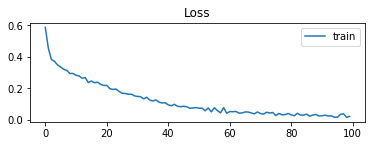

In [116]:
print(history)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
print(" ")
print(" ")


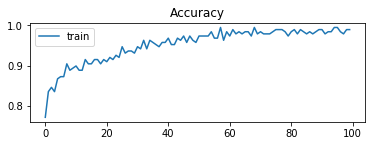

In [117]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [118]:
#from keras.utils import plot_model
#plot_model(model, expand_nested = True, show_shapes = True)

from IPython.display import SVG
from keras.utils import model_to_dot

import io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib

img = io.BytesIO()
png_img = model_to_dot(model).create(prog='dot', format='png')
img.write(png_img)
img.seek(0)
img = mpimg.imread(img)
plt.imshow(img)




Using TensorFlow backend.


Using matplotlib backend: MacOSX


In [119]:
predictions = model.predict(test)
print(predictions)

[[2.68109143e-02]
 [7.91609287e-04]
 [1.00000000e+00]
 [1.05190277e-03]
 [1.18017197e-05]
 [4.34237719e-03]
 [3.27825546e-07]
 [0.00000000e+00]
 [9.98930156e-01]
 [1.00000000e+00]
 [1.22231245e-02]
 [4.70578671e-05]
 [9.99814928e-01]
 [9.83773589e-01]
 [8.94069672e-08]
 [5.06639481e-07]
 [1.00000000e+00]
 [9.99969959e-01]
 [4.24377710e-01]
 [1.60932541e-06]
 [1.19209290e-07]
 [5.22850335e-01]
 [2.68220901e-07]
 [1.10268593e-06]
 [3.69723618e-01]
 [0.00000000e+00]
 [9.38340664e-01]
 [2.97419667e-01]
 [2.93016434e-04]
 [9.99999881e-01]
 [1.13248825e-06]
 [1.00000000e+00]
 [9.05990601e-06]
 [9.99999523e-01]
 [1.79708004e-05]
 [8.64267349e-07]
 [9.99997497e-01]
 [5.96046448e-08]
 [2.47088075e-03]
 [3.25527787e-03]
 [0.00000000e+00]
 [9.99999523e-01]
 [0.00000000e+00]
 [3.02270055e-03]
 [9.99933898e-01]
 [4.04421300e-01]
 [5.69655478e-01]
 [9.97240424e-01]
 [8.80002975e-04]
 [0.00000000e+00]
 [1.00000000e+00]
 [9.93406534e-01]
 [4.17232513e-07]
 [9.89029169e-01]
 [2.09212303e-05]
 [6.565093

In [122]:
tn, fp, fn, tp  = confusion_matrix(test_label, predictions.argmax(axis=1)).ravel()
print(tn,fp,fn,tp)

43 0 38 0


In [125]:
class_names = ["Absence","Presence"]


In [123]:
def plot_image(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i][0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  


  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i][0]
  plt.grid(True)
  plt.xticks([])
  #plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


In [127]:
test_label = test_label.astype(int)
test = test.astype(int)

In [128]:
i = 0

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_label)
plt.xticks(range(2), class_names, rotation=45)
plt.show()
# Blue bar is correct.  If red bar appears, it is the incorrect prediction of the model.

In [130]:
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_label)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_label)
    plt.xticks(range(2), class_names, rotation=45)
plt.show()



In [217]:
layer0 = model.get_layer(index=0)


In [218]:
layer0.get_weights()

[array([[ 1.09069988e-01, -2.87573814e-01, -2.23594517e-01,
         -4.43221815e-02,  6.99656233e-02,  1.98304400e-01,
          1.93546906e-01,  5.66738509e-02, -2.90854543e-01,
          1.52246431e-01,  1.82592362e-01,  1.11053601e-01,
          5.11174276e-02,  2.63167530e-01, -1.45223603e-01,
          3.08654547e-01,  6.44980138e-03, -2.81625062e-01,
          1.07838787e-01, -6.62568361e-02, -2.25442514e-01,
          1.54066309e-01,  3.09839044e-02, -2.01723754e-01,
          2.78022766e-01,  2.56228298e-01,  1.58240259e-01,
         -1.93813205e-01,  2.31730178e-01,  2.58179724e-01],
        [-2.77997226e-01,  2.72120591e-02,  2.00069379e-02,
         -1.65922627e-01, -7.84215927e-02,  2.37977996e-01,
          8.74396935e-02, -1.35304645e-01, -3.38924378e-01,
          1.67984031e-02,  2.67342538e-01,  6.94078356e-02,
         -2.23460849e-02, -1.79217532e-02, -2.82697231e-01,
         -2.32045844e-01,  1.17512882e-01, -2.36623019e-01,
          5.48212342e-02, -2.63546169e-

In [ ]:
layer1 = model.get_layer(index=1)

In [ ]:
layer1.get_weights()

In [98]:
#predictionsDF = pd.DataFrame(
#    data=predictions[1:,1:],    # values
#    index=predictions[1:,0],    # 1st column as index
#    columns=predictions[0,1:])  # 1st row as the column names

predictionsDF = pd.DataFrame(
    data=predictions)


In [ ]:
predictionsDF.to_csv("Predictions1.csv", encoding='utf-8', header=False, index=False)


In [99]:
PredictedLabels = np.ndarray.copy(TrainLabels)
PredictedOutcomes = np.ndarray.copy(TrainLabels)
for i in range(len(TrainLabels)):
  PredictedLabels[i] = np.argmax(predictions[i])
  if PredictedLabels[i] == TrainLabels[i]:
    PredictedOutcomes[i] = 1
  else:
    PredictedOutcomes[i] = 0


In [100]:
TrainDataLabels = np.append(TrainData, TrainLabels, axis=1)
TrainDataLabelsPredictions = np.append(TrainDataLabels, PredictedLabels, axis=1)
TrainDataLabelsPredictionsOutcomes = np.append(TrainDataLabelsPredictions, PredictedOutcomes, axis=1)
TrainDataLabelsPredictionsOutcomesProb = np.append(TrainDataLabelsPredictionsOutcomes, predictions, axis=1)


In [101]:
TDLPOP_DF = pd.DataFrame(
    data=TrainDataLabelsPredictionsOutcomesProb)

In [ ]:
TDLPOP_DF.to_csv("Predictions2.csv", encoding='utf-8', header=False, index=False)

In [102]:
#CycNorm, DefNorm, CosNorm
#Each ranges from 0 to 1
SingleObservation = np.array([[0.9, 0.9, 0.9]])
SinglePrediction = model.predict(SingleObservation)

ValueError: Input 0 of layer sequential_6 is incompatible with the layer: expected axis -1 of input shape to have value 28 but received input with shape [None, 3]

In [ ]:
SinglePrediction[0]

In [ ]:
np.max(SinglePrediction[0])

In [ ]:
np.argmax(SinglePrediction[0])

In [ ]:
class_names[np.argmax(SinglePrediction[0])]

In [ ]:
BlankLabels = np.array([[0, 0, 0, 0, 0]])

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, SinglePrediction, BlankLabels)
plt.subplot(1,2,2)
plot_value_array(i, SinglePrediction, BlankLabels)
plt.xticks(range(5), class_names, rotation=45)
plt.show()

In [ ]:
!date